# physionet2012 데이터 전처리
- 데이터 가져오기
- scaler 가져오기
- X, y 분리하기
- scaler 적용하기
- model에 입력가능한 3차원 형태 데이터 만들기
- (batch_size, maxlen, feature_dim)

In [1]:
# 전처리된 데이터 가져오기

import numpy as np
import pandas as pd

path = '/Users/jsha/gjai/final_project/black_swan_physionet/'
file = 'train_done_preprocessing.csv'
file2 = 'valid_done_preprocessing.csv'
file3 = 'test_done_preprocessing.csv'

train_df = pd.read_csv(path+file)
valid_df = pd.read_csv(path+file2)
test_df = pd.read_csv(path+file3)

maxlen = len(train_df[train_df['pid'] == train_df['pid'][0]])

In [2]:
# labels 컬럼 인덱스 찾기
inx = test_df.columns.get_indexer(['labels'])
print(inx)

# X, y 분리
y_train = train_df['labels']
X_train_nonorm = train_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_train.shape)
print(X_train_nonorm.shape)

y_valid = valid_df['labels']
X_valid_nonorm = valid_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_valid.shape)
print(X_valid_nonorm.shape)

y_test = test_df['labels']
X_test_nonorm = test_df.drop(columns=['pid', 'Gender', 'survival', 'surv_los', 'LOS', 'labels'])
print(y_test.shape)
print(X_test_nonorm.shape)

[41]
(226800,)
(226800, 40)
(25200,)
(25200, 40)
(28000,)
(28000, 40)


In [3]:
# scaler를 이용한 정규화

import pickle

mms = 'mms.pickle'
with open(path+mms, 'rb') as handler:
    load_mms = pickle.load(handler)
    
X_train = load_mms.transform(X_train_nonorm)
X_valid = load_mms.transform(X_valid_nonorm)
X_test = load_mms.transform(X_test_nonorm)

print(X_train.shape)
print(y_train.shape)
X_train_3d = X_train.reshape((-1, maxlen, X_train.shape[-1]))
print(X_train_3d.shape)
y_train_3d = y_train[::maxlen]
print(y_train_3d.shape)

X_valid_3d = X_valid.reshape((-1, maxlen, X_valid.shape[-1]))
print(X_valid_3d.shape)
y_valid_3d = y_valid[::maxlen]
print(y_valid_3d.shape)

X_test_3d = X_test.reshape((-1, maxlen, X_test.shape[-1]))
print(X_test_3d.shape)
y_test_3d = y_test[::maxlen]
print(y_test_3d.shape)

(226800, 40)
(226800,)
(3240, 70, 40)
(3240,)
(360, 70, 40)
(360,)
(400, 70, 40)
(400,)


# Model 설계 

## CNN

In [223]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D

feature_dim = X_train.shape[-1]

cnn_model = Sequential()
cnn_model.add(Conv1D(filters=32, kernel_size=4, activation='relu', input_shape=(maxlen, feature_dim)))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(8, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))



In [224]:
cnn_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_48 (Conv1D)          (None, 67, 32)            5152      
                                                                 
 dropout_120 (Dropout)       (None, 67, 32)            0         
                                                                 
 conv1d_49 (Conv1D)          (None, 66, 32)            2080      
                                                                 
 dropout_121 (Dropout)       (None, 66, 32)            0         
                                                                 
 dense_120 (Dense)           (None, 66, 64)            2112      
                                                                 
 dropout_122 (Dropout)       (None, 66, 64)            0         
                                                                 
 flatten_24 (Flatten)        (None, 4224)            

In [225]:
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', 'AUC'])

In [226]:
# 모델 학습하기

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 20
batch_size = 40
model_name = 'cnn_model.h5'

early_stopping = EarlyStopping(monitor='val_auc', patience=4, verbose=1)
checkpoint = ModelCheckpoint(path+model_name, monitor='val_auc', save_best_only=True)

cnn_history = cnn_model.fit(X_train_3d, y_train_3d, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_valid_3d, y_valid_3d), callbacks=[early_stopping, checkpoint])


Epoch 1/20
81/81 [==============================] - 2s 13ms/step - loss: 0.4115 - acc: 0.8630 - auc: 0.5765 - val_loss: 0.4678 - val_acc: 0.8639 - val_auc: 0.7538
Epoch 2/20
81/81 [==============================] - 1s 10ms/step - loss: 0.3698 - acc: 0.8682 - auc: 0.6870 - val_loss: 0.3387 - val_acc: 0.8639 - val_auc: 0.8115
Epoch 3/20
81/81 [==============================] - 1s 9ms/step - loss: 0.3542 - acc: 0.8682 - auc: 0.7377 - val_loss: 0.3897 - val_acc: 0.8639 - val_auc: 0.8145
Epoch 4/20
81/81 [==============================] - 1s 10ms/step - loss: 0.3437 - acc: 0.8682 - auc: 0.7603 - val_loss: 0.3694 - val_acc: 0.8639 - val_auc: 0.8124
Epoch 5/20
81/81 [==============================] - 1s 9ms/step - loss: 0.3364 - acc: 0.8682 - auc: 0.7743 - val_loss: 0.4329 - val_acc: 0.8639 - val_auc: 0.7806
Epoch 6/20
81/81 [==============================] - 1s 9ms/step - loss: 0.3361 - acc: 0.8682 - auc: 0.7720 - val_loss: 0.3341 - val_acc: 0.8639 - val_auc: 0.8028
Epoch 7/20
81/81 [=======

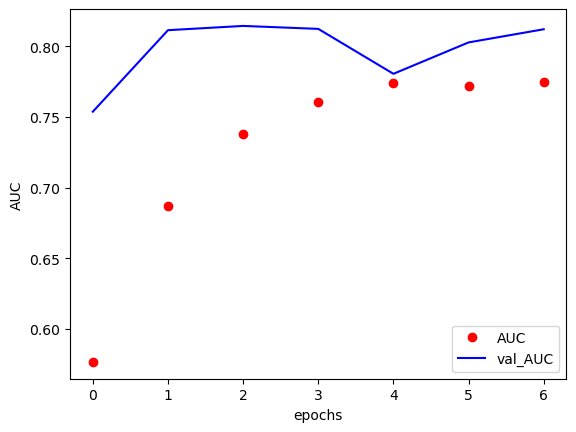

In [227]:
# epoch별 model acc 비교하기 

import matplotlib.pyplot as plt

history = cnn_history.history
history
loss = history['loss']
acc = history['acc']
auc = history['auc']
val_loss = history['val_loss']
val_acc = history['val_acc']
val_auc = history['val_auc']
length = len(val_loss)

plt.plot(range(length), auc, 'ro', label='AUC')
plt.plot(range(length), val_auc, 'b-', label='val_AUC')
plt.xlabel('epochs')
plt.ylabel('AUC')
plt.legend()

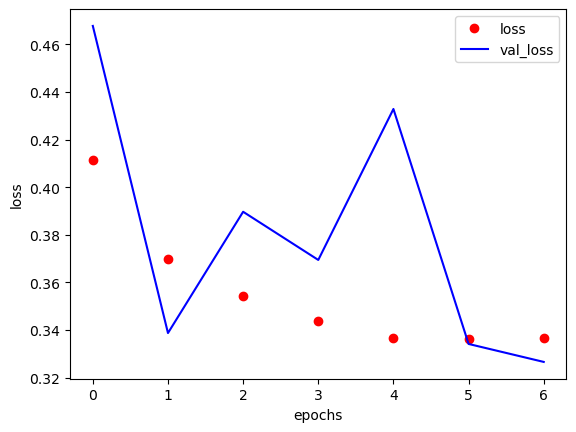

In [228]:
# epoch별 모델 loss 확인하기

plt.plot(range(length), loss, 'ro', label='loss')
plt.plot(range(length), val_loss, 'b-', label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [233]:
# test acc 구하기

test_loss, test_acc, test_auc = cnn_model.evaluate(X_test_3d, y_test_3d)
print(f'test_acc: {test_acc:.4f}')
print(f'test_auc: {test_auc:.4f}')

13/13 [==============================] - 0s 3ms/step - loss: 0.3102 - acc: 0.8700 - auc: 0.8185
test_acc: 0.8700
test_auc: 0.8185


In [234]:
from keras.models import load_model

loaded_model = load_model(path+'cnn_model.h5')

test_loss, test_acc, test_auc = loaded_model.evaluate(X_test_3d, y_test_3d)
test_pred = loaded_model.predict(X_test_3d)
auc = roc_auc_score(y_test_3d, test_pred)

print(f'acc_test: {test_acc:.4f}')
print(f'auc_score_test: {auc:.4f}')

13/13 [==============================] - 0s 3ms/step
acc_test: 0.8700
auc_score_test: 0.7191


In [235]:
# auroc 구하기

from sklearn.metrics import roc_auc_score

test_pred = cnn_model.predict(X_test_3d)
auc = roc_auc_score(y_test_3d, test_pred)

print(f'acc_test: {test_acc:.4f}')
print(f'auc_score_test: {auc:.4f}')

13/13 [==============================] - 0s 3ms/step
acc_test: 0.8700
auc_score_test: 0.8191


## CNN 모델 테스트 결과

- CNN이 LSTM보다는 auc가 잘 나옴
    - train data가 3차원이므로, Conv1D를 사용함.
- MaxPool1D는 생각보다 좋지 않음.
    - 사용이 미숙해서 그럴 수 있으므로 다시 차근히 이해하고 적용해보자.
- val_acc를 보며 학습이 잘 안된다고 했지만, 우리는 auc를 보고 판단할 것.